# Setting Learning Rate Optimally for Gradient Descent using Keras

In this notebook we explore various techniques to set the learning rate of the gradient descemt algorithm to Artificial Neural Network (ANNs). Our goal is to understand the optimal approach.

For experimentation, we build a Multi-Layer Perceptron (MLP) using Keras to classify MNIST handwritten digits dataset.

We perform three types of experiments.

- Experiment 1: Constant learning rate for Stochastic Gradient Descent (SGD) 
- Experiment 2: Learning rate schedule for SGD
- Experiment 3: Adaptive learning rates using extensions of SGD 


See the following notebook for a brief introduction to the convergence problem in the gradient descent algorithm in Deep ANNs and motivation for various optimizers: https://github.com/rhasanbd/Multi-Layer-Perceptron-Curious-Dabbling/blob/master/MLP-II-Nonlinear%20Data%20%26%20Multi-Layer%20Perceptron.ipynb

In [1]:
import warnings
import os
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score 

import tensorflow as tf
from tensorflow import keras

## Load the Dataset


We load the train and test dataset using Keras.

Then, we flatten the input images to create 1D array for each image.

Finally, create validation dataset and scale all data.

In [2]:
mnist = keras.datasets.mnist

(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

# Flatten the features to create 1D array for each image
X_train_full = X_train_full.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)


# Create validation dataset as well as scale the data
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.0

print("No. of Training Samples: ", X_train.shape)
print("No. of Training Labels: ", y_train.shape)

print("\nNo. of Validation Samples: ", X_valid.shape)
print("No. of Validation Labels: ", y_valid.shape)

print("\nNo. of Testing Samples: ", X_test.shape)
print("No. of Testing Labels: ", y_test.shape)

print("\nX type: ", X_train.dtype)
print("y type: ", y_train.dtype)

No. of Training Samples:  (55000, 784)
No. of Training Labels:  (55000,)

No. of Validation Samples:  (5000, 784)
No. of Validation Labels:  (5000,)

No. of Testing Samples:  (10000, 784)
No. of Testing Labels:  (10000,)

X type:  float64
y type:  uint8


## Experiment 1: Constant Learning Rate for SGD

Constant learning rate is the default learning rate schedule in SGD optimizer in Keras. Momentum is set to zero by default. It is tricky to choose the right learning rate. 

We perform the following experiment to find **an optimal constant learning rate**.

        To find an optimal constant learing rate we train the network for one epoch and grow the learning rate at each iteration. Then, by observing the change in loss at each iteration we find the optimal learning rate.

To increase the learning rate by a constant factor we define the following class.

In [3]:
'''
A class to increase the learning rate by a "factor" at each iteration.
It stores the changing learning rate and loss at each iteration.
'''

K = keras.backend

class IncreaseLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

### Experiment 1: Finding an Optimal Constant Learning Rate for SGD

We build a MLP classifier using Keras and use the SGD optimizer.

Then, we create an IncreaseLearningRate object (class defined above). It increases the learning rate by 0.5% at each iteration. We pass this object as a callback to the fit() method of the model.

We start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration. Then, using a loss vs. learning rate plot we find the optimal constant learning rate.

In [4]:
'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
- First Layer: It instantiates an input tensor for buildng the model 
- Hidden Layers: Dense hidden layer with the ReLU activation function
- Output Layer: Dense output layer with 10 neurons.
                Since it's a multi-class classification, we use "softmax"  
                activation function in the output layer. 
'''
model = keras.models.Sequential([
    keras.Input(shape=(784,)),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

     
# Define the optimizer
optimizer=keras.optimizers.SGD(learning_rate=1e-3)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

'''
Create an IncreaseLearningRate object.
It increases the learning rate by 0.5% at each iteration:
We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration.
'''
increase_lr = IncreaseLearningRate(factor=1.005)


history = model.fit(X_train, y_train, 
                    batch_size=32, # batch size 32 is default
                    epochs=1,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[increase_lr])

Train on 55000 samples, validate on 5000 samples
55000/55000 [==============================] - 5s 90us/sample - loss: nan - accuracy: 0.5764 - val_loss: nan - val_accuracy: 0.0958


### Experiment 1: Plot the Loss as a Function of the Learning Rate

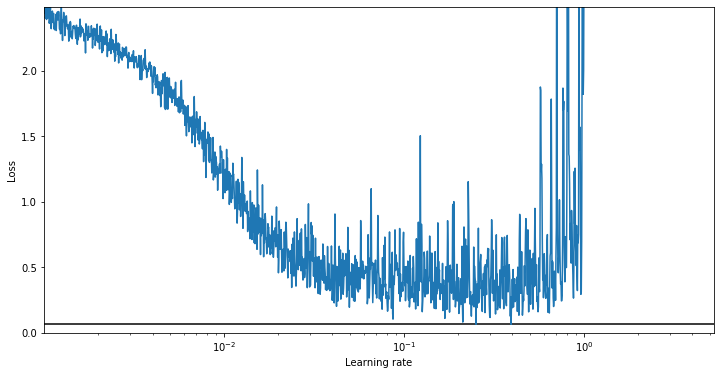

In [5]:
plt.figure(figsize = (12,6))
plt.plot(increase_lr.rates, increase_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(increase_lr.losses), min(increase_lr.rates), max(increase_lr.rates))
plt.axis([min(increase_lr.rates), max(increase_lr.rates), 0, increase_lr.losses[0]])
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.show()

### Observation:

We see that the loss starts shooting back up violently around 2e-1. Thus, we use 1e-1 as our learning rate.

#### Function For Generating Learning Curves (Accuracy & Loss)

In [6]:
def plot_learning_curves(history, numOfEpochs, title):
    plt.figure(figsize=(18,6))

    plt.subplot(121)
    plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
    plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
    plt.legend(loc=0)
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.xlim([1,numOfEpochs])
    plt.grid(True)
    plt.title("Model Accuracy: "+title)
    
    plt.subplot(122)
    plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
    plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
    plt.legend(loc=0)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.xlim([1,numOfEpochs])
    plt.grid(True)
    plt.title("Model Loss: "+title)
    
    plt.show() 

### Experiment 1: Train the MLP using the Optimal Constant Learning Rate for SGD

In [7]:
%%time

keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.Input(shape=(784,)),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])


optimizer=keras.optimizers.SGD(learning_rate=1e-1)


model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


# Create a callback object of early stopping
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

# Train the model
history_constant_lrate = model.fit(X_train, y_train, 
                    batch_size=32, # batch size 32 is default
                    epochs=100,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb])

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 4s 75us/sample - loss: 0.2713 - accuracy: 0.9188 - val_loss: 0.1140 - val_accuracy: 0.9694
Epoch 2/100
55000/55000 [==============================] - 4s 66us/sample - loss: 0.1105 - accuracy: 0.9667 - val_loss: 0.0862 - val_accuracy: 0.9764
Epoch 3/100
55000/55000 [==============================] - 3s 63us/sample - loss: 0.0756 - accuracy: 0.9770 - val_loss: 0.0768 - val_accuracy: 0.9766
Epoch 4/100
55000/55000 [==============================] - 3s 63us/sample - loss: 0.0540 - accuracy: 0.9833 - val_loss: 0.0708 - val_accuracy: 0.9794
Epoch 5/100
55000/55000 [==============================] - 3s 63us/sample - loss: 0.0401 - accuracy: 0.9876 - val_loss: 0.0729 - val_accuracy: 0.9786
Epoch 6/100
55000/55000 [==============================] - 3s 63us/sample - loss: 0.0305 - accuracy: 0.9907 - val_loss: 0.0780 - val_accuracy: 0.9818
Epoch 7/100
55000/55000 [==========================

### Experiment 1: Evaluate the Model & Generate Learning Curves

The "numOfEpochs" parameter should be set based on the number of epochs at which the training stopped (due to early stopping).

Epochs:  23
Constant Learning Rate - Train Accuracy:  0.9999273
Constant Learning Rate - Test Accuracy:  0.9813

Constant Learning Rate - Train Loss:  0.0015110199564922367
Constant Learning Rate - Test Loss:  0.06696832454066576


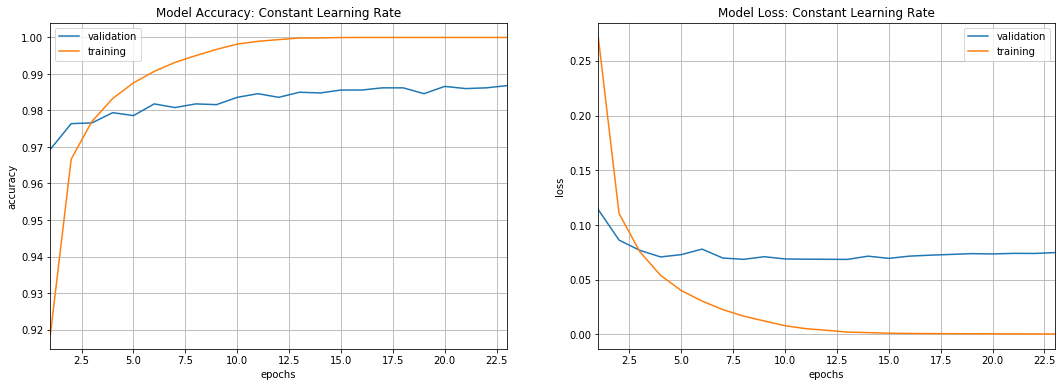

In [8]:
numOfEpochs_constant_lrate = len(history_constant_lrate.history['loss'])
print("Epochs: ", numOfEpochs_constant_lrate)

train_loss_constant_lrate = model.evaluate(X_train, y_train, verbose=0)[0]
train_accuracy_constant_lrate = model.evaluate(X_train, y_train, verbose=0)[1]

test_loss_constant_lrate = model.evaluate(X_test, y_test, verbose=0)[0]
test_accuracy_constant_lrate = model.evaluate(X_test, y_test, verbose=0)[1]

print("Constant Learning Rate - Train Accuracy: ", train_accuracy_constant_lrate)
print("Constant Learning Rate - Test Accuracy: ", test_accuracy_constant_lrate)

print("\nConstant Learning Rate - Train Loss: ", train_loss_constant_lrate)
print("Constant Learning Rate - Test Loss: ", test_loss_constant_lrate)

plot_learning_curves(history_constant_lrate, numOfEpochs_constant_lrate, "Constant Learning Rate")

## Experiment 1: Momentum infused Constant Learning Rate for SGD

- What is momentum?

The SGD algorithm tries to find the global minimum by adapting the weights. The loss function typically has a highly nonlinear dependence on the weights and bias parameters. Due to the non-convex nature of the loss function, in practice, multiple local minima may exist. Hence, there will be many points in the weight space at which the gradient vanishes (or is numerically very small).

Example of such places are: local minimum, saddle point and plateau. At these area, the gradient on every dimension (direction) "vanishes" and the weight update becomes extremely slow. At the worst case, the model stops training and returns the "optimized" weights.


The local minima, saddle points and plateau areas stall the training. There are other types of regions that can slow down the training significanty. The SGD algorithm itself is unable to guarantee faster convergence. Thus, to expedite the training time for converging to the near-global optimum we need to use faster optimizers.

A simple technique is to augment constant learning rate SGD with momentum. See the following notebook for a motivating discussion on momentum optimization:
https://github.com/rhasanbd/Multi-Layer-Perceptron-Curious-Dabbling/blob/master/MLP-II-Nonlinear%20Data%20%26%20Multi-Layer%20Perceptron.ipynb

Below we use a fixed value of momentum based on hyperparameter tuning reported in the following notebook:
https://github.com/rhasanbd/Smooth-Taste-of-Keras--Journey-Through-MLPs/blob/master/Keras-MLP%20Classifier-2-Hyperparameter%20Tuning.ipynb

In [9]:
%%time

keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

model_momentum = keras.models.Sequential([
    keras.Input(shape=(784,)),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])


optimizer=keras.optimizers.SGD(learning_rate=1e-1, momentum=0.1)


model_momentum.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)


history_constant_lrate_momentum = model_momentum.fit(X_train, y_train, 
                    batch_size=32, # batch size 32 is default
                    epochs=100,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb])

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 4s 74us/sample - loss: 0.2632 - accuracy: 0.9202 - val_loss: 0.1111 - val_accuracy: 0.9692
Epoch 2/100
55000/55000 [==============================] - 4s 67us/sample - loss: 0.1068 - accuracy: 0.9677 - val_loss: 0.0842 - val_accuracy: 0.9774
Epoch 3/100
55000/55000 [==============================] - 4s 66us/sample - loss: 0.0725 - accuracy: 0.9775 - val_loss: 0.0775 - val_accuracy: 0.9770
Epoch 4/100
55000/55000 [==============================] - 4s 67us/sample - loss: 0.0510 - accuracy: 0.9837 - val_loss: 0.0729 - val_accuracy: 0.9786
Epoch 5/100
55000/55000 [==============================] - 4s 66us/sample - loss: 0.0375 - accuracy: 0.9887 - val_loss: 0.0680 - val_accuracy: 0.9808
Epoch 6/100
55000/55000 [==============================] - 4s 66us/sample - loss: 0.0281 - accuracy: 0.9914 - val_loss: 0.0744 - val_accuracy: 0.9814
Epoch 7/100
55000/55000 [==========================

Epochs:  19
Constant Learning Rate with Momentum - Train Accuracy:  0.9992727
Constant Learning Rate with Momentum - Test Accuracy:  0.9832

Constant Learning Rate with Momentum - Train Loss:  0.005108292749064805
Constant Learning Rate with Momentum - Test Loss:  0.06106927128024836


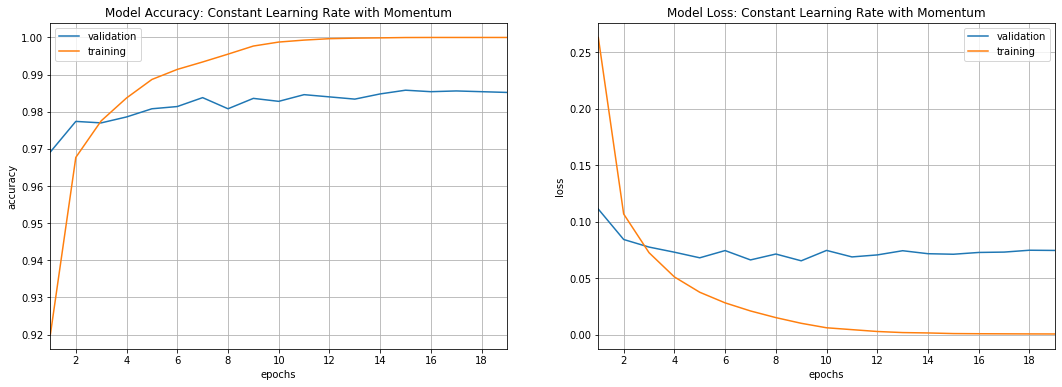

In [10]:
numOfEpochs_constant_lrate_momentum = len(history_constant_lrate_momentum.history['loss'])
print("Epochs: ", numOfEpochs_constant_lrate_momentum)

train_loss_constant_lrate_momentum = model_momentum.evaluate(X_train, y_train, verbose=0)[0]
train_accuracy_constant_lrate_momentum = model_momentum.evaluate(X_train, y_train, verbose=0)[1]

test_loss_constant_lrate_momentum = model_momentum.evaluate(X_test, y_test, verbose=0)[0]
test_accuracy_constant_lrate_momentum = model_momentum.evaluate(X_test, y_test, verbose=0)[1]

print("Constant Learning Rate with Momentum - Train Accuracy: ", train_accuracy_constant_lrate_momentum)
print("Constant Learning Rate with Momentum - Test Accuracy: ", test_accuracy_constant_lrate_momentum)

print("\nConstant Learning Rate with Momentum - Train Loss: ", train_loss_constant_lrate_momentum)
print("Constant Learning Rate with Momentum - Test Loss: ", test_loss_constant_lrate_momentum)

plot_learning_curves(history_constant_lrate_momentum, numOfEpochs_constant_lrate_momentum, "Constant Learning Rate with Momentum")

## Experiment 2: Learning Rate Schedule for SGD


The training has two goals:
- Reach the global minimum 
- Reach there as fast as possible

Thus, initially we could set the learning rate at a large value so that we could reach toward the valley faster. It helps make quick progress and escape local minima. Then, as we approach the valley we reduce it slowly so that it converges to the global minimum. 

To accomplish this, we define a function that determines the learning rate at each iteration. It is called the learning schedule.

Defining a good learning schedule is tricky. Because:
- If the learning rate is reduced too quickly, we may get stuck in a local minimum, or even end up frozen halfway to the minimum. 
- If the learning rate is reduced too slowly, we may jump around the minimum for a long time and end up with a suboptimal solution if we halt training too early.

Thus, we explore 3 different learning schedules and see how they perform.
- Step Decay
- Exponential Decay
- Time-based Decay

In addition to this, we explore Keras' **ReduceLROnPlateau callback** class. It is used to adjust the learning rate when a plateau in model performance is detected (i.e., no change for a given number of training epochs). 




## Experiment 2: Step Decay Learning Schedule

Step decay schedule drops the learning rate by a factor every few epochs. 

The mathematical form of step decay is :

- $lr = lr_0 * drop^{floor(\frac{epoch}{ epochs\_drop})} $

A simple heuristic is to drop the learning rate by half every 10 epochs. 

First, we define the step decay function.

Then, we pass it as an argument of the **LearningRateScheduler callback**: https://keras.io/api/callbacks/learning_rate_scheduler/

At the beginning of every epoch, the learning rate scheduler callback gets the updated learning rate value from the learning rate schedule function (e.g., step decay function), with the current epoch and current learning rate (2nd argument of the learning schedule function), and applies the updated learning rate on the optimizer.


Also, we define a class to store the changing loss and learning rates at each epoch.

In [11]:
def step_decay(epoch, lr):
    initial_lrate = lr
    drop = 0.5
    epochs_drop = 10
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    
    return lrate


# A class to store the changing loss and learning rates at each epoch.
class LossHistory_StepDecay(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(step_decay(len(self.losses), self.model.optimizer.lr))

### Function to Plot Learning Rate

In [12]:
# plot learning rate
def plot_learning_rate(loss_history_lschedule, numOfEpochs, title):
    plt.figure(figsize=(10,6))
    plt.plot(range(1,numOfEpochs+1),loss_history_lschedule.lr,label='learning rate')
    plt.xlabel("epoch")
    plt.xlim([1,numOfEpochs+1])
    plt.ylabel("learning rate")
    plt.legend(loc=0)
    plt.grid(True)
    plt.title(title)
    plt.show()

### Experiment 2: Training using Step Decay Learning Schedule

In [13]:
%%time

keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

model_step_decay = keras.models.Sequential([
    keras.Input(shape=(784,)),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])


optimizer=keras.optimizers.SGD(learning_rate=1e-1, momentum=0.1)


model_step_decay.compile(loss="sparse_categorical_crossentropy",
                         optimizer=optimizer,
                         metrics=["accuracy"])


early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

loss_history_step_decay_cb = LossHistory_StepDecay()

lschedule_step_decay_cb = keras.callbacks.LearningRateScheduler(step_decay, verbose=1)


history_step_decay = model_step_decay.fit(X_train, y_train, 
                               batch_size=32, # batch size 32 is default
                               epochs=100,
                               verbose=1,
                               validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb, loss_history_step_decay_cb, lschedule_step_decay_cb])

Train on 55000 samples, validate on 5000 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 1/100
55000/55000 [==============================] - 4s 74us/sample - loss: 0.2632 - accuracy: 0.9202 - val_loss: 0.1111 - val_accuracy: 0.9692

Epoch 00002: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 2/100
55000/55000 [==============================] - 4s 66us/sample - loss: 0.1068 - accuracy: 0.9677 - val_loss: 0.0842 - val_accuracy: 0.9774

Epoch 00003: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 3/100
55000/55000 [==============================] - 4s 66us/sample - loss: 0.0725 - accuracy: 0.9775 - val_loss: 0.0775 - val_accuracy: 0.9770

Epoch 00004: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 4/100
55000/55000 [==============================] - 4s 66us/sample - loss: 0.0510 - accuracy: 0.9837 - val_loss: 0.0729 - val_accuracy: 0.9786

Epoch 00005: Learn

### Experiment 2: Evaluate using Step Decay Learning Schedule

Epochs:  22
Step Decay - Train Accuracy:  0.99994546
Step Decay - Test Accuracy:  0.9843

Step Decay - Train Loss:  0.0019597146637028674
Step Decay - Test Loss:  0.05966613053493966


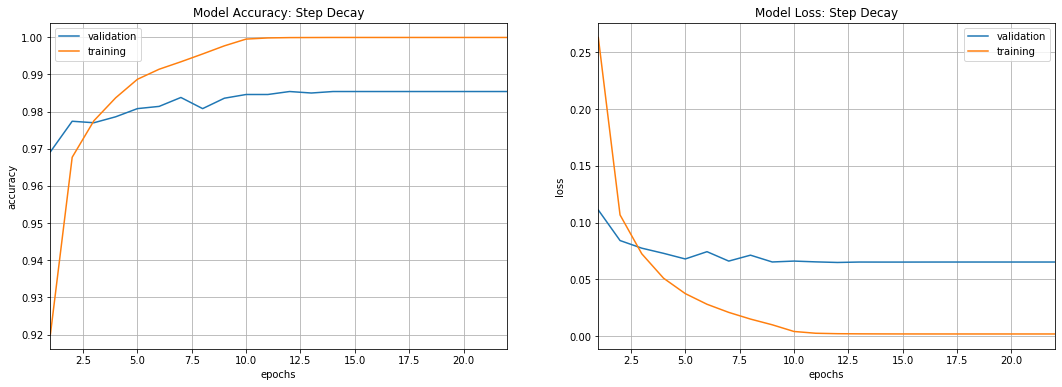

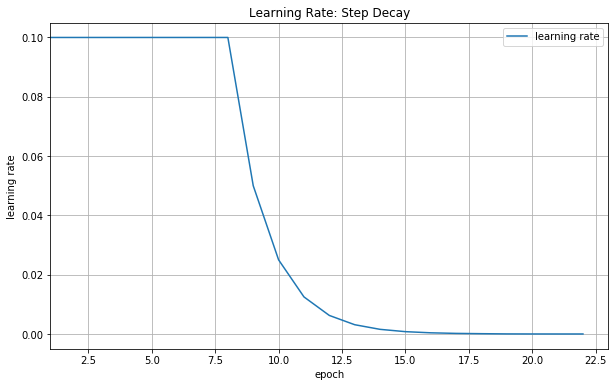

In [14]:
numOfEpochs_step_decay = len(history_step_decay.history['loss'])
print("Epochs: ", numOfEpochs_step_decay)

train_loss_step_decay = model_step_decay.evaluate(X_train, y_train, verbose=0)[0]
train_accuracy_step_decay = model_step_decay.evaluate(X_train, y_train, verbose=0)[1]

test_loss_step_decay = model_step_decay.evaluate(X_test, y_test, verbose=0)[0]
test_accuracy_step_decay = model_step_decay.evaluate(X_test, y_test, verbose=0)[1]

print("Step Decay - Train Accuracy: ", train_accuracy_step_decay)
print("Step Decay - Test Accuracy: ", test_accuracy_step_decay)

print("\nStep Decay - Train Loss: ", train_loss_step_decay)
print("Step Decay - Test Loss: ", test_loss_step_decay)

plot_learning_curves(history_step_decay, numOfEpochs_step_decay, "Step Decay")

plot_learning_rate(loss_history_step_decay_cb, numOfEpochs_step_decay, "Learning Rate: Step Decay")

## Experiment 2: Exponential Decay Learning Schedule


Exponential Decay
The mathematical form of exponential decay is:

- $lr = lr_0 * e^{−k*epoch}$


Here $k$ is a hyperparameter.



In [15]:
def exp_decay(epoch, lr):
    initial_lrate = lr
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate


# A class to store the changing loss and learning rates at each epoch.
class LossHistory_ExpDecay(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay(len(self.losses), self.model.optimizer.lr))

### Experiment 2: Training using Exponential Decay Learning Schedule

In [16]:
%%time

keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

model_exp_decay = keras.models.Sequential([
    keras.Input(shape=(784,)),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])


optimizer=keras.optimizers.SGD(learning_rate=1e-1, momentum=0.1)


model_exp_decay.compile(loss="sparse_categorical_crossentropy",
                         optimizer=optimizer,
                         metrics=["accuracy"])


early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

loss_history_exp_decay_cb = LossHistory_ExpDecay()

lschedule_exp_decay_cb = keras.callbacks.LearningRateScheduler(exp_decay, verbose=1)


history_exp_decay = model_exp_decay.fit(X_train, y_train, 
                               batch_size=32, # batch size 32 is default
                               epochs=100,
                               verbose=1,
                               validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb, loss_history_exp_decay_cb, lschedule_exp_decay_cb])

Train on 55000 samples, validate on 5000 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 1/100
55000/55000 [==============================] - 4s 73us/sample - loss: 0.2632 - accuracy: 0.9202 - val_loss: 0.1111 - val_accuracy: 0.9692

Epoch 00002: LearningRateScheduler reducing learning rate to 0.09048374315190877.
Epoch 2/100
55000/55000 [==============================] - 4s 67us/sample - loss: 0.1047 - accuracy: 0.9683 - val_loss: 0.0842 - val_accuracy: 0.9764

Epoch 00003: LearningRateScheduler reducing learning rate to 0.07408182056868164.
Epoch 3/100
55000/55000 [==============================] - 4s 66us/sample - loss: 0.0678 - accuracy: 0.9792 - val_loss: 0.0769 - val_accuracy: 0.9780

Epoch 00004: LearningRateScheduler reducing learning rate to 0.05488116446995039.
Epoch 4/100
55000/55000 [==============================] - 4s 66us/sample - loss: 0.0444 - accuracy: 0.9866 - val_loss: 0.0686 - val_accuracy: 0.9812

Epoch 00005: Learn

### Experiment 2: Evaluate using Exponential Decay Learning Schedule

Epochs:  20
Exponential Decay - Train Accuracy:  0.99707276
Exponential Decay - Test Accuracy:  0.9812

Exponential Decay - Train Loss:  0.016329389887616376
Exponential Decay - Test Loss:  0.0594958289390197


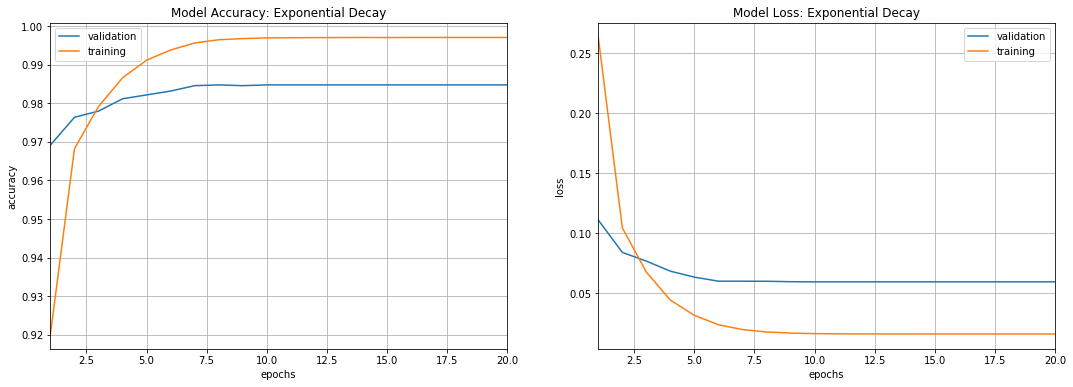

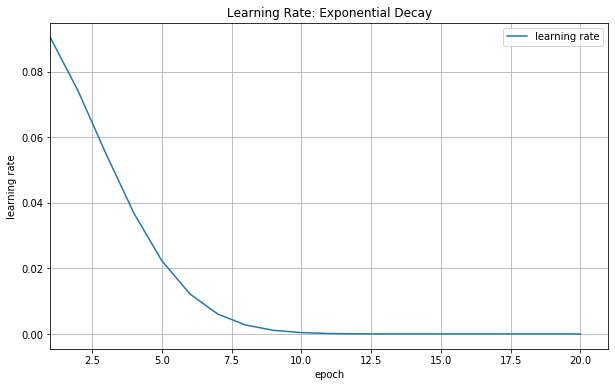

In [17]:
numOfEpochs_exp_decay = len(history_exp_decay.history['loss'])
print("Epochs: ", numOfEpochs_exp_decay)

train_loss_exp_decay = model_exp_decay.evaluate(X_train, y_train, verbose=0)[0]
train_accuracy_exp_decay = model_exp_decay.evaluate(X_train, y_train, verbose=0)[1]

test_loss_exp_decay = model_exp_decay.evaluate(X_test, y_test, verbose=0)[0]
test_accuracy_exp_decay = model_exp_decay.evaluate(X_test, y_test, verbose=0)[1]

print("Exponential Decay - Train Accuracy: ", train_accuracy_exp_decay)
print("Exponential Decay - Test Accuracy: ", test_accuracy_exp_decay)

print("\nExponential Decay - Train Loss: ", train_loss_exp_decay)
print("Exponential Decay - Test Loss: ", test_loss_exp_decay)


plot_learning_curves(history_exp_decay, numOfEpochs_exp_decay, "Exponential Decay")

plot_learning_rate(loss_history_exp_decay_cb, numOfEpochs_exp_decay, "Learning Rate: Exponential Decay")

## Experiment 2: Time-based Decay Learning Schedule


The mathematical form of time-based decay is: 

- $lr = \frac{lr_0}{(1 + decay * epoch)}$ 


In [18]:
def time_based_decay(epoch, lr):
    initial_lrate = lr
    decay = 0.1    
    lrate = initial_lrate * (1.0 / (1.0 + decay * epoch))
    return lrate


# A class to store the changing loss and learning rates at each epoch.
class LossHistory_TimeBasedDecay(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(time_based_decay(len(self.losses), self.model.optimizer.lr))

### Experiment 2: Training using Time-based Decay Learning Schedule

In [19]:
%%time

keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

model_time_based_decay = keras.models.Sequential([
    keras.Input(shape=(784,)),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])


optimizer=keras.optimizers.SGD(learning_rate=1e-1, momentum=0.1)


model_time_based_decay.compile(loss="sparse_categorical_crossentropy",
                         optimizer=optimizer,
                         metrics=["accuracy"])


early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

loss_history_time_based_decay_cb = LossHistory_TimeBasedDecay()

lschedule_time_based_decay_cb = keras.callbacks.LearningRateScheduler(time_based_decay, verbose=1)


history_time_based_decay = model_time_based_decay.fit(X_train, y_train, 
                               batch_size=32, # batch size 32 is default
                               epochs=100,
                               verbose=1,
                               validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb, loss_history_time_based_decay_cb, lschedule_time_based_decay_cb])

Train on 55000 samples, validate on 5000 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 1/100
55000/55000 [==============================] - 4s 76us/sample - loss: 0.2632 - accuracy: 0.9202 - val_loss: 0.1111 - val_accuracy: 0.9692

Epoch 00002: LearningRateScheduler reducing learning rate to 0.09090909226374193.
Epoch 2/100
55000/55000 [==============================] - 4s 67us/sample - loss: 0.1049 - accuracy: 0.9682 - val_loss: 0.0841 - val_accuracy: 0.9764

Epoch 00003: LearningRateScheduler reducing learning rate to 0.07575757801532745.
Epoch 3/100
55000/55000 [==============================] - 4s 67us/sample - loss: 0.0679 - accuracy: 0.9792 - val_loss: 0.0777 - val_accuracy: 0.9766

Epoch 00004: LearningRateScheduler reducing learning rate to 0.05827506001179034.
Epoch 4/100
55000/55000 [==============================] - 4s 68us/sample - loss: 0.0449 - accuracy: 0.9863 - val_loss: 0.0688 - val_accuracy: 0.9812

Epoch 00005: Learn

### Experiment 2: Evaluation using Time-based Decay Learning Schedule

Epochs:  20
Time-based Decay - Train Accuracy:  0.9978909
Time-based Decay - Test Accuracy:  0.9818

Time-based Decay - Train Loss:  0.014125963965380057
Time-based Decay - Test Loss:  0.059078281933249675


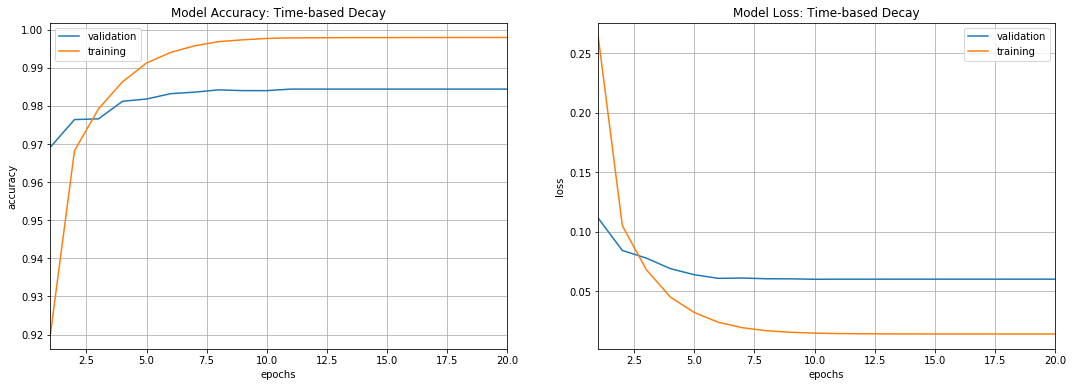

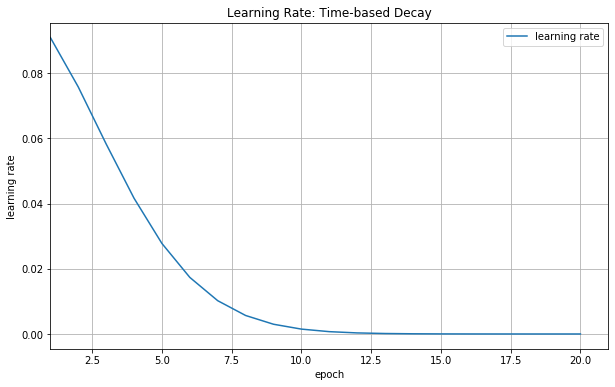

In [20]:
numOfEpochs_time_based_decay = len(history_time_based_decay.history['loss'])
print("Epochs: ", numOfEpochs_time_based_decay)

train_loss_time_based_decay = model_time_based_decay.evaluate(X_train, y_train, verbose=0)[0]
train_accuracy_time_based_decay = model_time_based_decay.evaluate(X_train, y_train, verbose=0)[1]

test_loss_time_based_decay = model_time_based_decay.evaluate(X_test, y_test, verbose=0)[0]
test_accuracy_time_based_decay = model_time_based_decay.evaluate(X_test, y_test, verbose=0)[1]

print("Time-based Decay - Train Accuracy: ", train_accuracy_time_based_decay)
print("Time-based Decay - Test Accuracy: ", test_accuracy_time_based_decay)

print("\nTime-based Decay - Train Loss: ", train_loss_time_based_decay)
print("Time-based Decay - Test Loss: ", test_loss_time_based_decay)


plot_learning_curves(history_time_based_decay, numOfEpochs_time_based_decay, "Time-based Decay")

plot_learning_rate(loss_history_time_based_decay_cb, numOfEpochs_time_based_decay, "Learning Rate: Time-based Decay")

## Experiment 2: Learning Schedule by Keras' ReduceLROnPlateau callback class


Keras provides the ReduceLROnPlateau callback class that to adjust the learning rate when a plateau in model performance is detected (i.e., no change for a given number of training epochs). This callback is designed to reduce the learning rate after the model stops improving with the hope of fine-tuning model weights.

https://keras.io/api/callbacks/reduce_lr_on_plateau/

The ReduceLROnPlateau requires us to specify the metric to monitor during training via the "monitor" argument, the value that the learning rate will be multiplied by via the "factor" argument and the "patience" argument that specifies the number of training epochs to wait before triggering the change in learning rate.

For example, we can monitor the validation loss and reduce the learning rate by an order of magnitude if validation loss does not improve for 10 epochs:

In [21]:
K = keras.backend

class LossHistory_ReduceLROnPlateau(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(K.get_value(self.model.optimizer.lr))

### Experiment 2: Training using Keras' ReduceLROnPlateau callback based Learning Schedule

In [22]:
%%time

keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

model_ReduceLROnPlateau = keras.models.Sequential([
    keras.Input(shape=(784,)),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])


optimizer=keras.optimizers.SGD(learning_rate=1e-1, momentum=0.1)

model_ReduceLROnPlateau.compile(loss="sparse_categorical_crossentropy",
                         optimizer=optimizer,
                         metrics=["accuracy"])


early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

loss_history_ReduceLROnPlateau_cb = LossHistory_ReduceLROnPlateau()

lschedule_ReduceLROnPlateau_cb = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=10, min_lr=0.001, verbose=1)



history_ReduceLROnPlateau = model_ReduceLROnPlateau.fit(X_train, y_train, 
                               batch_size=32, # batch size 32 is default
                               epochs=100,
                               verbose=1,
                               validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb, loss_history_ReduceLROnPlateau_cb, lschedule_ReduceLROnPlateau_cb])

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 4s 73us/sample - loss: 0.2632 - accuracy: 0.9202 - val_loss: 0.1111 - val_accuracy: 0.9692
Epoch 2/100
55000/55000 [==============================] - 4s 66us/sample - loss: 0.1068 - accuracy: 0.9677 - val_loss: 0.0842 - val_accuracy: 0.9774
Epoch 3/100
55000/55000 [==============================] - 4s 66us/sample - loss: 0.0725 - accuracy: 0.9775 - val_loss: 0.0775 - val_accuracy: 0.9770
Epoch 4/100
55000/55000 [==============================] - 4s 66us/sample - loss: 0.0510 - accuracy: 0.9837 - val_loss: 0.0729 - val_accuracy: 0.9786
Epoch 5/100
55000/55000 [==============================] - 4s 67us/sample - loss: 0.0375 - accuracy: 0.9887 - val_loss: 0.0680 - val_accuracy: 0.9808
Epoch 6/100
55000/55000 [==============================] - 4s 67us/sample - loss: 0.0281 - accuracy: 0.9914 - val_loss: 0.0744 - val_accuracy: 0.9814
Epoch 7/100
55000/55000 [==========================

### Experiment 2: Evaluation using Keras' ReduceLROnPlateau callback based Learning Schedule

Epochs:  19
Time-based Decay - Train Accuracy:  0.9992727
Time-based Decay - Test Accuracy:  0.9832

Time-based Decay - Train Loss:  0.005108292749064805
Time-based Decay - Test Loss:  0.06106927128024836


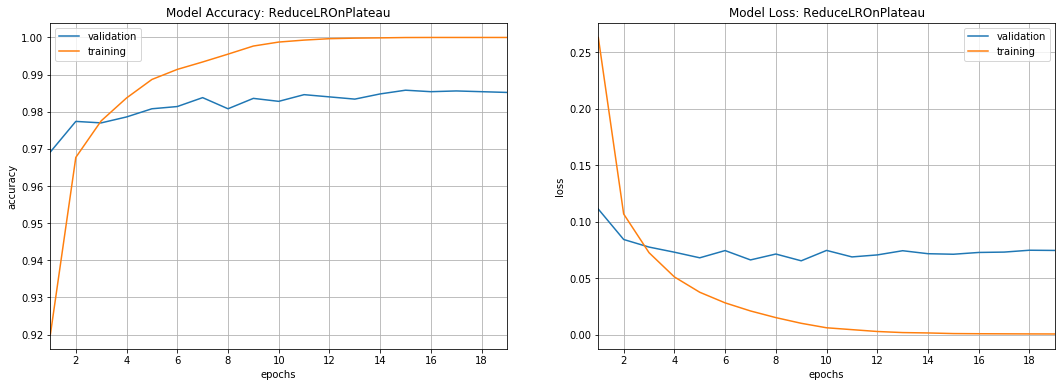

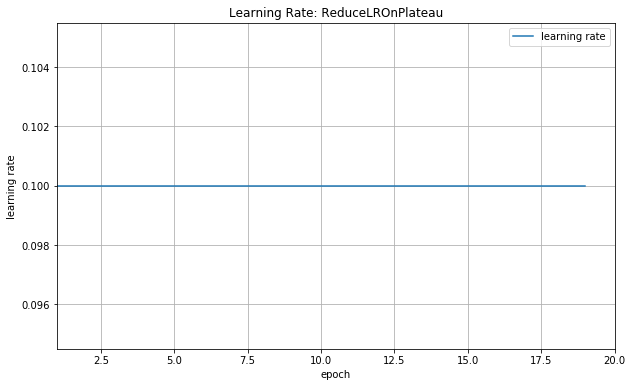

In [23]:
numOfEpochs_ReduceLROnPlateau = len(history_ReduceLROnPlateau.history['loss'])
print("Epochs: ", numOfEpochs_ReduceLROnPlateau )

train_loss_ReduceLROnPlateau = model_ReduceLROnPlateau.evaluate(X_train, y_train, verbose=0)[0]
train_accuracy_ReduceLROnPlateau = model_ReduceLROnPlateau.evaluate(X_train, y_train, verbose=0)[1]

test_loss_ReduceLROnPlateau = model_ReduceLROnPlateau.evaluate(X_test, y_test, verbose=0)[0]
test_accuracy_ReduceLROnPlateau = model_ReduceLROnPlateau.evaluate(X_test, y_test, verbose=0)[1]

print("Time-based Decay - Train Accuracy: ", train_accuracy_ReduceLROnPlateau)
print("Time-based Decay - Test Accuracy: ", test_accuracy_ReduceLROnPlateau)

print("\nTime-based Decay - Train Loss: ", train_loss_ReduceLROnPlateau)
print("Time-based Decay - Test Loss: ", test_loss_ReduceLROnPlateau)


plot_learning_curves(history_ReduceLROnPlateau, numOfEpochs_ReduceLROnPlateau , "ReduceLROnPlateau")

plot_learning_rate(loss_history_ReduceLROnPlateau_cb, numOfEpochs_ReduceLROnPlateau , "Learning Rate: ReduceLROnPlateau")

# Experiment 3: Adaptive Learning Rates using Extensions of SGD


There are two limitations of using learning schedules with SGD.

- The biggest limitation is that we need to define the hyperparameters in advance. The optimal settings depend on the model architecture and the data.

- The same learning rate is applied to all parameter updates. If we have sparse data, we may want to update the parameters in different extent instead.

These limitations are addressed by **Adaptive gradient descent algorithms**. 

These algorithms provide per-parameter learning rate. These are based on heuristic approach without requiring expensive work in tuning hyperparameters for the learning rate schedule manually.

We explore the following adaptive learning rate algorithms:
- Adagrad
- Adadelta
- RMSprop
- Adam
- Nadam


To understand the motivation behind adaptive learning rate algorithms, see the discussion in this notebook:
https://github.com/rhasanbd/Multi-Layer-Perceptron-Curious-Dabbling/blob/master/MLP-II-Nonlinear%20Data%20%26%20Multi-Layer%20Perceptron.ipynb


A quick comparatiove discussion of these algorithms reveal that **Adagrad** performs larger updates for more sparse parameters and smaller updates for less sparse parameter. It has good performance with sparse data and training large-scale neural networks. However, its monotonic learning rate usually proves too aggressive and stops learning too early when training deep neural networks. **Adadelta** is an extension of Adagrad that seeks to reduce its aggressive, monotonically decreasing learning rate. **RMSprop** adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressive, monotonically decreasing learning rate. **Adam** is an update to the RMSProp optimizer which is like RMSprop with momentum. **Nadam**  accelerates the speed of Adam with Nesterov momentum.

Keras provides functions for these adaptive learning algorithms that we can use with corresponding optimizers. It is usually recommended to leave the hyperparameters of these optimizers at their default values. 

- The only hyperparameter that we might need to adjust is the learning rate.

## Experiment 3: Adaptive Learning Rate by Adagrad Optimizer

Adagrad is an optimizer with parameter-specific learning rates, which are adapted relative to how frequently a parameter gets updated during training. 

The more updates a parameter receives, the smaller the updates.

In [24]:
K = keras.backend

class LossHistory_Adagrad(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(K.get_value(self.model.optimizer.lr))

### Experiment 3: Training using Adagrad Optimizer

In [25]:
%%time

keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

model_Adagrad = keras.models.Sequential([
    keras.Input(shape=(784,)),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])



optimizer=keras.optimizers.Adagrad(lr=0.05, epsilon=1e-07, decay=0.0)

model_Adagrad.compile(loss="sparse_categorical_crossentropy",
                         optimizer=optimizer,
                         metrics=["accuracy"])


early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

loss_history_Adagrad_cb = LossHistory_Adagrad()


history_Adagrad = model_Adagrad.fit(X_train, y_train, 
                               batch_size=32, # batch size 32 is default
                               epochs=100,
                               verbose=1,
                               validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb, loss_history_Adagrad_cb])

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 5s 90us/sample - loss: 0.2422 - accuracy: 0.9266 - val_loss: 0.1021 - val_accuracy: 0.9716
Epoch 2/100
55000/55000 [==============================] - 4s 80us/sample - loss: 0.0973 - accuracy: 0.9709 - val_loss: 0.0822 - val_accuracy: 0.9772
Epoch 3/100
55000/55000 [==============================] - 4s 81us/sample - loss: 0.0646 - accuracy: 0.9799 - val_loss: 0.0701 - val_accuracy: 0.9780
Epoch 4/100
55000/55000 [==============================] - 4s 80us/sample - loss: 0.0442 - accuracy: 0.9862 - val_loss: 0.0666 - val_accuracy: 0.9794
Epoch 5/100
55000/55000 [==============================] - 4s 80us/sample - loss: 0.0325 - accuracy: 0.9902 - val_loss: 0.0653 - val_accuracy: 0.9814
Epoch 6/100
55000/55000 [==============================] - 4s 80us/sample - loss: 0.0229 - accuracy: 0.9936 - val_loss: 0.0686 - val_accuracy: 0.9822
Epoch 7/100
55000/55000 [==========================

### Experiment 3: Evaluation using Adagrad Optimizer

Epochs:  18
Time-based Decay - Train Accuracy:  0.9985273
Time-based Decay - Test Accuracy:  0.9824

Time-based Decay - Train Loss:  0.00850829096620225
Time-based Decay - Test Loss:  0.06213632559640391


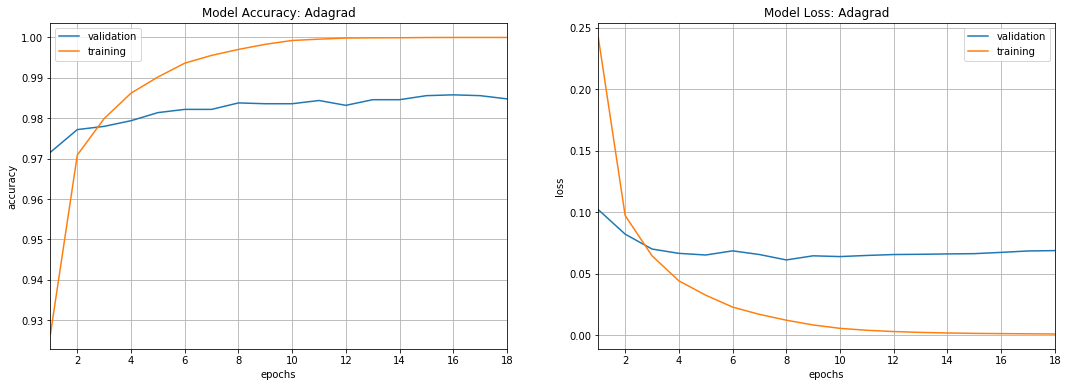

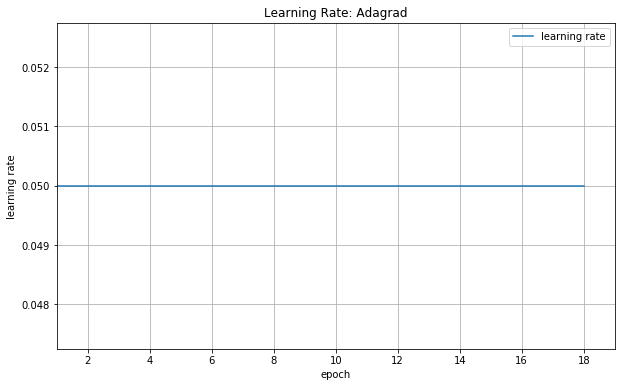

In [26]:
numOfEpochs_Adagrad = len(history_Adagrad.history['loss'])
print("Epochs: ", numOfEpochs_Adagrad )

train_loss_Adagrad = model_Adagrad.evaluate(X_train, y_train, verbose=0)[0]
train_accuracy_Adagrad = model_Adagrad.evaluate(X_train, y_train, verbose=0)[1]

test_loss_Adagrad = model_Adagrad.evaluate(X_test, y_test, verbose=0)[0]
test_accuracy_Adagrad = model_Adagrad.evaluate(X_test, y_test, verbose=0)[1]

print("Time-based Decay - Train Accuracy: ", train_accuracy_Adagrad)
print("Time-based Decay - Test Accuracy: ", test_accuracy_Adagrad)

print("\nTime-based Decay - Train Loss: ", train_loss_Adagrad)
print("Time-based Decay - Test Loss: ", test_loss_Adagrad)


plot_learning_curves(history_Adagrad, numOfEpochs_Adagrad , "Adagrad")

plot_learning_rate(loss_history_Adagrad_cb, numOfEpochs_Adagrad , "Learning Rate: Adagrad")

## Experiment 3: Adaptive Learning Rate by Adadelta Optimizer


Adadelta is a **more robust extension of Adagrad** that adapts learning rates based on a moving window of gradient updates, instead of accumulating all past gradients. This way, Adadelta continues learning even when many updates have been done. 

Adadelta optimization is a stochastic gradient descent method that is based on adaptive learning rate per dimension to address two drawbacks:

- The continual decay of learning rates throughout training
- The need for a manually selected global learning rate


Compared to Adagrad, in the original version of Adadelta we don't have to set an initial learning rate. In this version, initial learning rate can be set, as in most other Keras optimizers.

#### Note that the performance of the model is sensitive to the initial learning rate of the Adagrad optimizer.

In [27]:
K = keras.backend

class LossHistory_Adadelta(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(K.get_value(self.model.optimizer.lr))

### Experiment 3: Training using Adadelta Optimizer

In [28]:
%%time

keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

model_Adadelta = keras.models.Sequential([
    keras.Input(shape=(784,)),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])



optimizer=keras.optimizers.Adadelta(lr=0.1, rho=0.95, epsilon=1e-07, decay=0.0)

model_Adadelta.compile(loss="sparse_categorical_crossentropy",
                         optimizer=optimizer,
                         metrics=["accuracy"])


early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

loss_history_Adadelta_cb = LossHistory_Adadelta()


history_Adadelta = model_Adadelta.fit(X_train, y_train, 
                               batch_size=32, # batch size 32 is default
                               epochs=100,
                               verbose=1,
                               validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb, loss_history_Adadelta_cb])

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 4s 81us/sample - loss: 0.4676 - accuracy: 0.8760 - val_loss: 0.2533 - val_accuracy: 0.9272
Epoch 2/100
55000/55000 [==============================] - 4s 74us/sample - loss: 0.2346 - accuracy: 0.9329 - val_loss: 0.1911 - val_accuracy: 0.9458
Epoch 3/100
55000/55000 [==============================] - 4s 75us/sample - loss: 0.1843 - accuracy: 0.9475 - val_loss: 0.1638 - val_accuracy: 0.9552
Epoch 4/100
55000/55000 [==============================] - 4s 75us/sample - loss: 0.1527 - accuracy: 0.9561 - val_loss: 0.1368 - val_accuracy: 0.9610
Epoch 5/100
55000/55000 [==============================] - 4s 74us/sample - loss: 0.1310 - accuracy: 0.9624 - val_loss: 0.1262 - val_accuracy: 0.9644
Epoch 6/100
55000/55000 [==============================] - 4s 74us/sample - loss: 0.1148 - accuracy: 0.9676 - val_loss: 0.1117 - val_accuracy: 0.9672
Epoch 7/100
55000/55000 [==========================

### Experiment 3: Evaluation using Adadelta Optimizer

Epochs:  44
Time-based Decay - Train Accuracy:  0.99725455
Time-based Decay - Test Accuracy:  0.9807

Time-based Decay - Train Loss:  0.013808173238299788
Time-based Decay - Test Loss:  0.06758231818986242


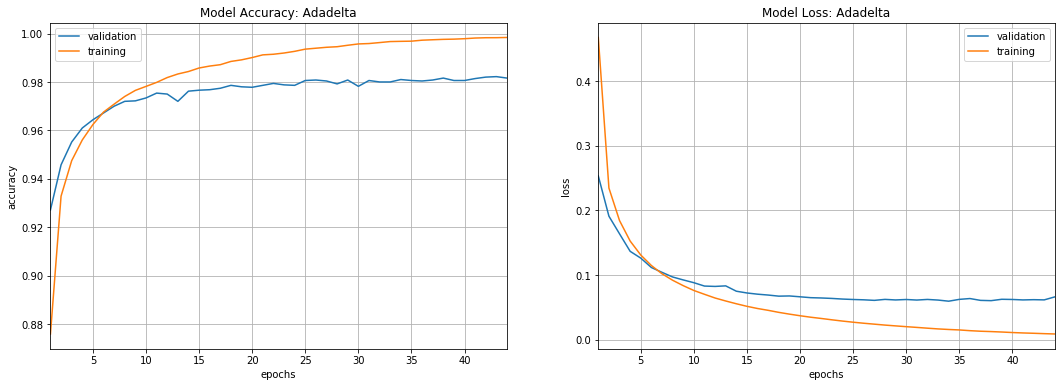

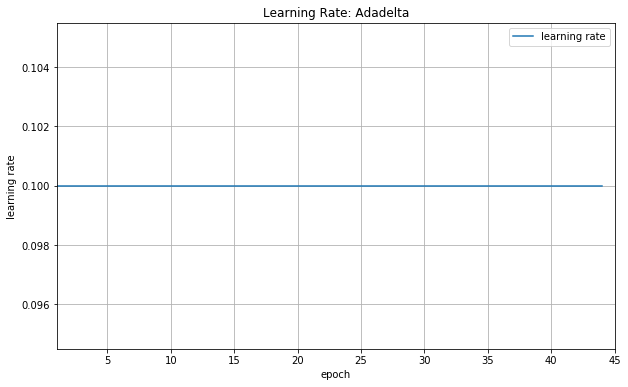

In [29]:
numOfEpochs_Adadelta = len(history_Adadelta.history['loss'])
print("Epochs: ", numOfEpochs_Adadelta )

train_loss_Adadelta = model_Adadelta.evaluate(X_train, y_train, verbose=0)[0]
train_accuracy_Adadelta = model_Adadelta.evaluate(X_train, y_train, verbose=0)[1]

test_loss_Adadelta = model_Adadelta.evaluate(X_test, y_test, verbose=0)[0]
test_accuracy_Adadelta = model_Adadelta.evaluate(X_test, y_test, verbose=0)[1]

print("Time-based Decay - Train Accuracy: ", train_accuracy_Adadelta)
print("Time-based Decay - Test Accuracy: ", test_accuracy_Adadelta)

print("\nTime-based Decay - Train Loss: ", train_loss_Adadelta)
print("Time-based Decay - Test Loss: ", test_loss_Adadelta)


plot_learning_curves(history_Adadelta, numOfEpochs_Adadelta , "Adadelta")

plot_learning_rate(loss_history_Adadelta_cb, numOfEpochs_Adadelta , "Learning Rate: Adadelta")


## Experiment 3: Adaptive Learning Rate by RMSprop Optimizer


The gist of RMSprop is to:

- Maintain a moving (discounted) average of the square of gradients
- Divide the gradient by the root of this average

This implementation of RMSprop uses plain momentum, not Nesterov momentum.


#### Note that the performance of the model is sensitive to the initial learning rate of the RMSprop optimizer. The learning rate should be set to a smaller value.

In [30]:
K = keras.backend

class LossHistory_RMSprop(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(K.get_value(self.model.optimizer.lr))

### Experiment 3: Training using RMSprop Optimizer

In [31]:
%%time

keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

model_RMSprop = keras.models.Sequential([
    keras.Input(shape=(784,)),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])



optimizer=keras.optimizers.RMSprop(lr=0.0005, rho=0.9, epsilon=1e-07, decay=0.0)

model_RMSprop.compile(loss="sparse_categorical_crossentropy",
                         optimizer=optimizer,
                         metrics=["accuracy"])


early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

loss_history_RMSprop_cb = LossHistory_RMSprop()


history_RMSprop = model_RMSprop.fit(X_train, y_train, 
                               batch_size=32, # batch size 32 is default
                               epochs=100,
                               verbose=1,
                               validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb, loss_history_RMSprop_cb])

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 6s 102us/sample - loss: 0.2529 - accuracy: 0.9261 - val_loss: 0.1060 - val_accuracy: 0.9694
Epoch 2/100
55000/55000 [==============================] - 5s 86us/sample - loss: 0.1047 - accuracy: 0.9682 - val_loss: 0.0897 - val_accuracy: 0.9748
Epoch 3/100
55000/55000 [==============================] - 5s 84us/sample - loss: 0.0755 - accuracy: 0.9783 - val_loss: 0.0791 - val_accuracy: 0.9768
Epoch 4/100
55000/55000 [==============================] - 5s 83us/sample - loss: 0.0568 - accuracy: 0.9830 - val_loss: 0.0780 - val_accuracy: 0.9766
Epoch 5/100
55000/55000 [==============================] - 5s 84us/sample - loss: 0.0469 - accuracy: 0.9866 - val_loss: 0.0836 - val_accuracy: 0.9756
Epoch 6/100
55000/55000 [==============================] - 5s 89us/sample - loss: 0.0379 - accuracy: 0.9886 - val_loss: 0.0758 - val_accuracy: 0.9798
Epoch 7/100
55000/55000 [=========================

### Experiment 3: Evaluation using RMSprop Optimizer

Epochs:  16
Time-based Decay - Train Accuracy:  0.99127275
Time-based Decay - Test Accuracy:  0.9788

Time-based Decay - Train Loss:  0.029207672208443877
Time-based Decay - Test Loss:  0.07923325493456505


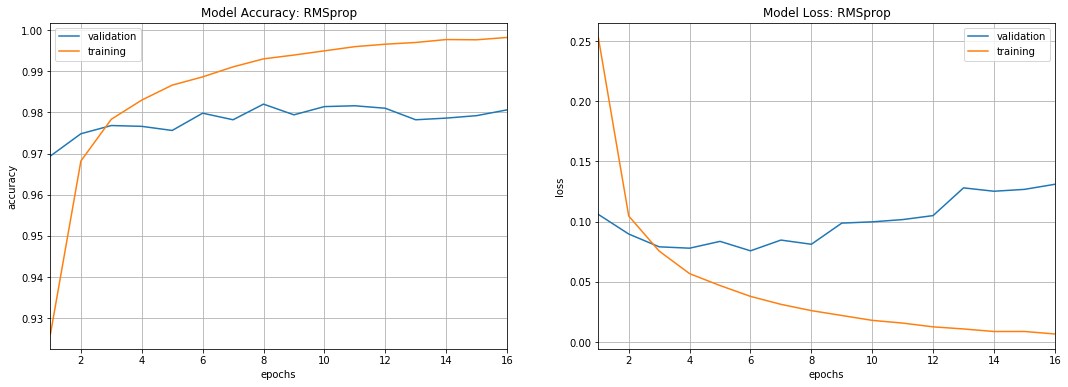

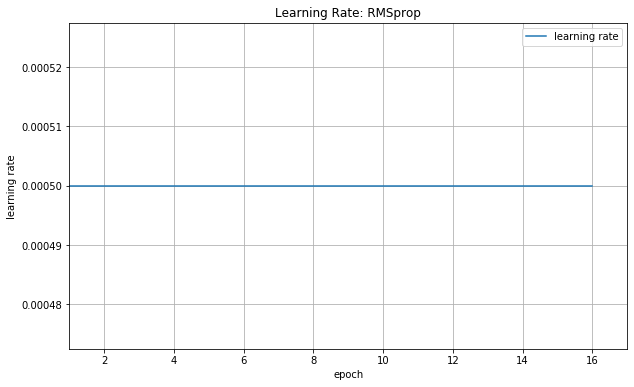

In [32]:
numOfEpochs_RMSprop = len(history_RMSprop.history['loss'])
print("Epochs: ", numOfEpochs_RMSprop )

train_loss_RMSprop = model_RMSprop.evaluate(X_train, y_train, verbose=0)[0]
train_accuracy_RMSprop = model_RMSprop.evaluate(X_train, y_train, verbose=0)[1]

test_loss_RMSprop = model_RMSprop.evaluate(X_test, y_test, verbose=0)[0]
test_accuracy_RMSprop = model_RMSprop.evaluate(X_test, y_test, verbose=0)[1]

print("Time-based Decay - Train Accuracy: ", train_accuracy_RMSprop)
print("Time-based Decay - Test Accuracy: ", test_accuracy_RMSprop)

print("\nTime-based Decay - Train Loss: ", train_loss_RMSprop)
print("Time-based Decay - Test Loss: ", test_loss_RMSprop)


plot_learning_curves(history_RMSprop, numOfEpochs_RMSprop , "RMSprop")

plot_learning_rate(loss_history_RMSprop_cb, numOfEpochs_RMSprop , "Learning Rate: RMSprop")


## Experiment 3: Adaptive Learning Rate by Adam Optimizer


Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.


#### Note that the performance of the model is sensitive to the initial learning rate of the Adam optimizer. The learning rate should be set to a smaller value.

In [33]:
K = keras.backend

class LossHistory_Adam(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(K.get_value(self.model.optimizer.lr))

### Experiment 3: Training using Adam Optimizer

In [34]:
%%time

keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

model_Adam = keras.models.Sequential([
    keras.Input(shape=(784,)),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])



optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.0)

model_Adam.compile(loss="sparse_categorical_crossentropy",
                         optimizer=optimizer,
                         metrics=["accuracy"])


early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

loss_history_Adam_cb = LossHistory_Adam()


history_Adam = model_Adam.fit(X_train, y_train, 
                               batch_size=32, # batch size 32 is default
                               epochs=100,
                               verbose=1,
                               validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb, loss_history_Adam_cb])

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 4s 81us/sample - loss: 0.4783 - accuracy: 0.8757 - val_loss: 0.2304 - val_accuracy: 0.9324
Epoch 2/100
55000/55000 [==============================] - 4s 73us/sample - loss: 0.2062 - accuracy: 0.9418 - val_loss: 0.1641 - val_accuracy: 0.9556
Epoch 3/100
55000/55000 [==============================] - 4s 70us/sample - loss: 0.1520 - accuracy: 0.9563 - val_loss: 0.1369 - val_accuracy: 0.9642
Epoch 4/100
55000/55000 [==============================] - 4s 70us/sample - loss: 0.1197 - accuracy: 0.9655 - val_loss: 0.1104 - val_accuracy: 0.9686
Epoch 5/100
55000/55000 [==============================] - 4s 70us/sample - loss: 0.0985 - accuracy: 0.9716 - val_loss: 0.1032 - val_accuracy: 0.9712
Epoch 6/100
55000/55000 [==============================] - 4s 70us/sample - loss: 0.0828 - accuracy: 0.9768 - val_loss: 0.0867 - val_accuracy: 0.9744
Epoch 7/100
55000/55000 [==========================

### Experiment 3: Evaluation using Adam Optimizer

Epochs:  27
Time-based Decay - Train Accuracy:  0.9981091
Time-based Decay - Test Accuracy:  0.9789

Time-based Decay - Train Loss:  0.012481681516648016
Time-based Decay - Test Loss:  0.07266299106132938


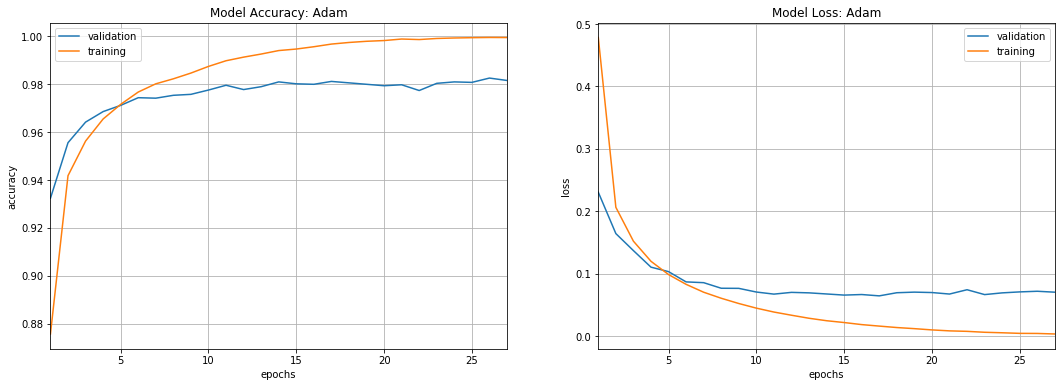

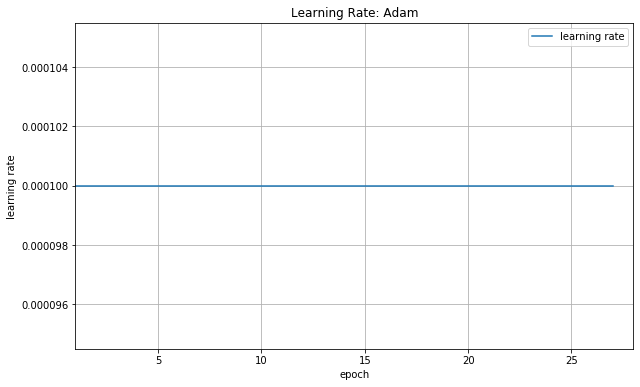

In [35]:
numOfEpochs_Adam = len(history_Adam.history['loss'])
print("Epochs: ", numOfEpochs_Adam )

train_loss_Adam = model_Adam.evaluate(X_train, y_train, verbose=0)[0]
train_accuracy_Adam = model_Adam.evaluate(X_train, y_train, verbose=0)[1]

test_loss_Adam = model_Adam.evaluate(X_test, y_test, verbose=0)[0]
test_accuracy_Adam = model_Adam.evaluate(X_test, y_test, verbose=0)[1]

print("Time-based Decay - Train Accuracy: ", train_accuracy_Adam)
print("Time-based Decay - Test Accuracy: ", test_accuracy_Adam)

print("\nTime-based Decay - Train Loss: ", train_loss_Adam)
print("Time-based Decay - Test Loss: ", test_loss_Adam)


plot_learning_curves(history_Adam, numOfEpochs_Adam , "Adam")

plot_learning_rate(loss_history_Adam_cb, numOfEpochs_Adam , "Learning Rate: Adam")


## Experiment 3: Adaptive Learning Rate by NAdam Optimizer

Nadam is Adam with Nesterov momentum.

In [36]:
K = keras.backend

class LossHistory_Nadam(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(K.get_value(self.model.optimizer.lr))

### Experiment 3: Training using NAdam Optimizer

In [37]:
%%time

keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

model_Nadam = keras.models.Sequential([
    keras.Input(shape=(784,)),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])


optimizer=keras.optimizers.Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)


model_Nadam.compile(loss="sparse_categorical_crossentropy",
                         optimizer=optimizer,
                         metrics=["accuracy"])


early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

loss_history_Nadam_cb = LossHistory_Nadam()


history_Nadam = model_Nadam.fit(X_train, y_train, 
                               batch_size=32, # batch size 32 is default
                               epochs=100,
                               verbose=1,
                               validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb, loss_history_Nadam_cb])

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 6s 115us/sample - loss: 0.4787 - accuracy: 0.8750 - val_loss: 0.2294 - val_accuracy: 0.9342
Epoch 2/100
55000/55000 [==============================] - 5s 100us/sample - loss: 0.2057 - accuracy: 0.9416 - val_loss: 0.1631 - val_accuracy: 0.9558
Epoch 3/100
55000/55000 [==============================] - 6s 102us/sample - loss: 0.1516 - accuracy: 0.9562 - val_loss: 0.1363 - val_accuracy: 0.9638
Epoch 4/100
55000/55000 [==============================] - 5s 97us/sample - loss: 0.1194 - accuracy: 0.9658 - val_loss: 0.1098 - val_accuracy: 0.9690
Epoch 5/100
55000/55000 [==============================] - 5s 96us/sample - loss: 0.0982 - accuracy: 0.9721 - val_loss: 0.1033 - val_accuracy: 0.9712
Epoch 6/100
55000/55000 [==============================] - 5s 97us/sample - loss: 0.0825 - accuracy: 0.9767 - val_loss: 0.0866 - val_accuracy: 0.9744
Epoch 7/100
55000/55000 [=======================

### Experiment 3: Evaluation using NAdam Optimizer

Epochs:  27
Time-based Decay - Train Accuracy:  0.9979636
Time-based Decay - Test Accuracy:  0.978

Time-based Decay - Train Loss:  0.01309707196764648
Time-based Decay - Test Loss:  0.07381657590167597


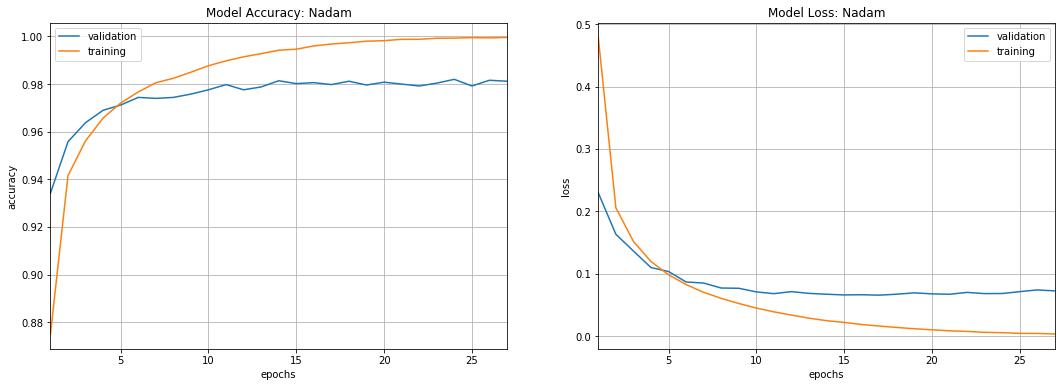

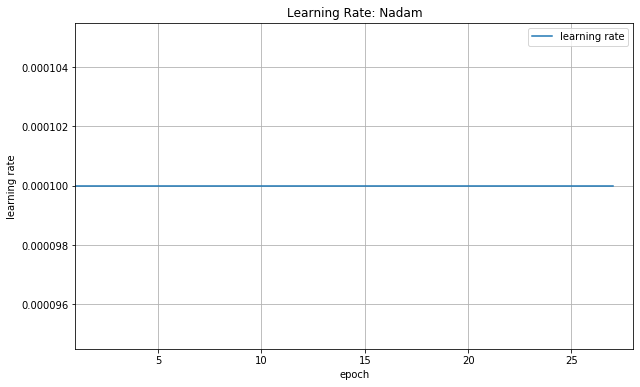

In [38]:
numOfEpochs_Nadam = len(history_Nadam.history['loss'])
print("Epochs: ", numOfEpochs_Nadam )

train_loss_Nadam = model_Nadam.evaluate(X_train, y_train, verbose=0)[0]
train_accuracy_Nadam = model_Nadam.evaluate(X_train, y_train, verbose=0)[1]

test_loss_Nadam = model_Nadam.evaluate(X_test, y_test, verbose=0)[0]
test_accuracy_Nadam = model_Nadam.evaluate(X_test, y_test, verbose=0)[1]

print("Time-based Decay - Train Accuracy: ", train_accuracy_Nadam)
print("Time-based Decay - Test Accuracy: ", test_accuracy_Nadam)

print("\nTime-based Decay - Train Loss: ", train_loss_Nadam)
print("Time-based Decay - Test Loss: ", test_loss_Nadam)


plot_learning_curves(history_Nadam, numOfEpochs_Nadam , "Nadam")

plot_learning_rate(loss_history_Nadam_cb, numOfEpochs_Nadam , "Learning Rate: Nadam")


# Comparison of Validation Accuracy Over Epochs

44


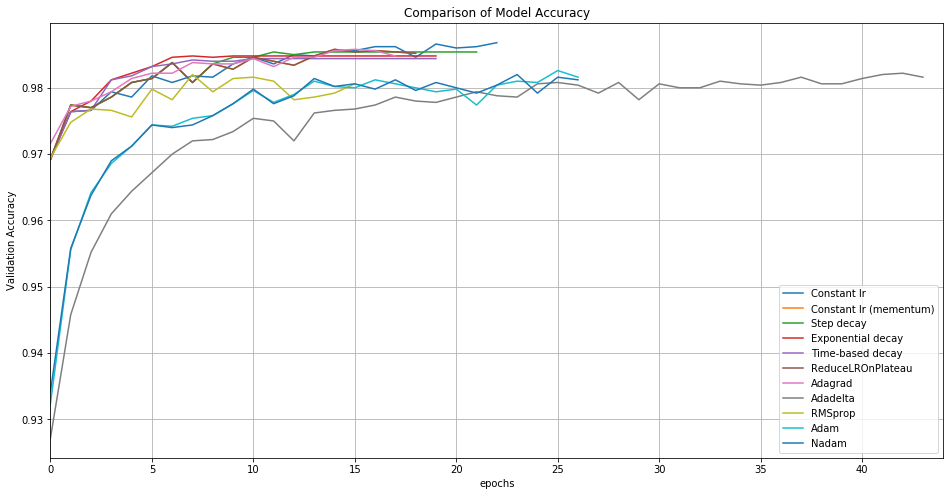

In [39]:
epochs = max(numOfEpochs_constant_lrate, numOfEpochs_constant_lrate_momentum,
             numOfEpochs_step_decay, numOfEpochs_exp_decay, numOfEpochs_time_based_decay, numOfEpochs_ReduceLROnPlateau,
             numOfEpochs_Adagrad, numOfEpochs_Adadelta, numOfEpochs_RMSprop, numOfEpochs_Adam, numOfEpochs_Nadam)
print(epochs)

plt.figure(figsize=(16,8))
plt.plot(range(numOfEpochs_constant_lrate),history_constant_lrate.history['val_accuracy'],label='Constant lr')
plt.plot(range(numOfEpochs_constant_lrate_momentum),history_constant_lrate_momentum.history['val_accuracy'],label='Constant lr (mementum)')
plt.plot(range(numOfEpochs_step_decay),history_step_decay.history['val_accuracy'],label='Step decay')
plt.plot(range(numOfEpochs_exp_decay),history_exp_decay.history['val_accuracy'],label='Exponential decay')
plt.plot(range(numOfEpochs_time_based_decay),history_time_based_decay.history['val_accuracy'],label='Time-based decay')

plt.plot(range(numOfEpochs_ReduceLROnPlateau),history_ReduceLROnPlateau.history['val_accuracy'],label='ReduceLROnPlateau')
plt.plot(range(numOfEpochs_Adagrad),history_Adagrad.history['val_accuracy'],label='Adagrad')
plt.plot(range(numOfEpochs_Adadelta),history_Adadelta.history['val_accuracy'],label='Adadelta')
plt.plot(range(numOfEpochs_RMSprop),history_RMSprop.history['val_accuracy'],label='RMSprop')
plt.plot(range(numOfEpochs_Adam),history_Adam.history['val_accuracy'],label='Adam')
plt.plot(range(numOfEpochs_Nadam),history_Nadam.history['val_accuracy'],label='Nadam')
plt.legend(loc=0)
plt.xlabel('epochs')
plt.xlim([0,epochs])
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.title("Comparison of Model Accuracy")
plt.show()

# Comparison of Test Accuracy and Total Number of Epochs

In [40]:
data = [
    ["SGD Const. Learning Rate", numOfEpochs_constant_lrate, test_accuracy_constant_lrate],
    ["SGD Const. Learning Rate (momentum)", numOfEpochs_constant_lrate_momentum, test_accuracy_constant_lrate_momentum],
    ["SGD Step Decay", numOfEpochs_step_decay, test_accuracy_step_decay],
    ["SGD Exponential Decay", numOfEpochs_exp_decay, test_accuracy_exp_decay],
    ["SGD Time-based Decay", numOfEpochs_time_based_decay, test_accuracy_time_based_decay],
    ["SGD ReduceLROnPlateau", numOfEpochs_ReduceLROnPlateau, test_accuracy_ReduceLROnPlateau],
    ["Adagrad", numOfEpochs_Adagrad, test_accuracy_Adagrad],
    ["Adadelta", numOfEpochs_Adadelta, test_accuracy_Adadelta],
    ["RMSprop", numOfEpochs_RMSprop, test_accuracy_RMSprop],
    ["Adam", numOfEpochs_Adam, test_accuracy_Adam],
    ["NAdam", numOfEpochs_Nadam, test_accuracy_Nadam]
       ]
pd.DataFrame(data, columns=["Name", "Epochs", "Test Accuracy"])

,Name,Epochs,Test Accuracy
0,SGD Const. Learning Rate,23,0.9813
1,SGD Const. Learning Rate (momentum),19,0.9832
2,SGD Step Decay,22,0.9843
3,SGD Exponential Decay,20,0.9812
4,SGD Time-based Decay,20,0.9818
5,SGD ReduceLROnPlateau,19,0.9832
6,Adagrad,18,0.9824
7,Adadelta,44,0.9807
8,RMSprop,16,0.9788
9,Adam,27,0.9789


# Overall Observation

We see that SGD (using momentum) with **step decay** learning schedule provides the higest test accuracy within 22 epochs.

The **Adagrad** performs better than other adaptive learning rate algorithms. Since MNIST is a smaller dataset and is less complex as compared to typical Deep Learning problems, we woudn't see the benefit of the adaptive learning rate algorithms. Thus, these experiments should be approached from the perspective of an illustrative understanding.